In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import time
import random
from collections import deque
import tensorflow as tf
from tqdm import tqdm 
from tensorflow.keras import Sequential 
from tensorflow.keras.activations import relu, linear
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import RMSprop
import math
from random import sample
from tensorflow.keras.optimizers import Adam
from tqdm import trange
import pandas as pd
import gc
import os


In [2]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs:", len(physical_devices))

Num GPUs: 1


In [3]:
state_space=8
obs_space=5
action_space=4
intermediate_dim=16

In [4]:
# from lunar_lander_2 import LunarLander
# env = LunarLander('LunarLander-v2',
#     continuous= False,
#     gravity = -10.0,
#     enable_wind = True,
#     wind_power = 5.0,
#     turbulence_power= 0.5)
env= gym.make(
        "LunarLander-v2",
        continuous = False,
        gravity = -10.0,
        enable_wind = True,
        wind_power  = 5.0,
        turbulence_power = 0.5
    )

In [5]:

GAMMA = 0.99
LEARNING_RATE = 2.5e-4

MEMORY_SIZE = 10000
BATCH_SIZE = 64

EPSILON_MAX = 1.0
EPSILON_MIN = 0.01
EXPLORATION_DECAY = 0.995

In [6]:
class QModel:
    def __init__(self, input_dim, output_dim, lr):
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.lr = lr
        self.Qpolicy = self.create()
        self.Qtarget = self.create() 
        self.Qtarget.set_weights(self.Qpolicy.get_weights())
        
    def create(self):
        model = Sequential()
        model.add(tf.keras.layers.InputLayer(input_shape=(1,self.input_dim)))
        model.add(Dense(512,activation = 'relu',kernel_initializer='he_uniform'))
        model.add(Dense(256, activation = 'relu',kernel_initializer='he_uniform'))
        model.add(Dense(128, activation = 'relu',kernel_initializer='he_uniform'))
        model.add(Dense(self.output_dim, activation = 'linear',kernel_initializer='he_uniform'))
        model.compile(optimizer = RMSprop(learning_rate = self.lr, rho = 0.95, epsilon = 1e-7), loss = "mse", metrics = ['accuracy'])
        return model

In [7]:
class DQNSolver:
    def __init__(self, state_space,action_space, decay_coe = 0.998, 
                  memory_size = 10000,  C = 5,LEARNING_RATE=1e-4,GAMMA=1,EPSILON_MAX=1.0,EPSILON_MIN=0.01,BATCH_SIZE=64):
        
        #self.env = gym.make('CartPole-v0')

        self.states = state_space
        self.n_actions = action_space
        
        self.actions = [i for i in range(self.n_actions)]
        
        self.lr = LEARNING_RATE
        self.gamma = GAMMA
        self.epsilon = EPSILON_MAX
        self.decay_coe = decay_coe
        self.min_eps = EPSILON_MIN
        #self.episodes = episodes
        self.batch_size = BATCH_SIZE
        self.memory = deque(maxlen = memory_size) # replay memory 
        #self.C = C
        
        self.terminal_state = False # end of the episode
        self.target_counter = 0 
        
        # Plot data
        #self.timestep = self.episodes / 10

        
        
        
        self.model = QModel(self.states, self.n_actions, self.lr)
        self.positive_rewards_list=[]
        # Smooth epsilon 
        # self.a = 0.35
        # self.b = 0.1
        # self.c = 0.01
    def find_positive_rewards(self):
        self.positive_rewards_list=[]
        for i,x in enumerate(self.memory):
            if x[2]>10:
                self.positive_rewards_list.append(i)
    def state_shape(self,states):
        states = np.array(states)
        return states.reshape(-1,*states.shape)
    def update_target_model(self):
        """
        Updates the current target_q_net with the q_net which brings all the
        training in the q_net to the target_q_net.
        :return: None
        """
        self.model.Qtarget.set_weights(self.model.Qpolicy.get_weights())
    def decrement_epsilon(self):
        '''
        if self.epsilon > self.min_eps:
            self.epsilon *= self.decay_coe
        else:
            self.epsilon = self.min_eps
        '''
        # s_time = (time - self.a*self.episodes) / (self.b*self.episodes) 
        # cosh = np.cosh(math.exp(-s_time))
        # self.epsilon = 1 - (1/cosh + (time*self.c/self.episodes))
        if self.epsilon>self.min_eps:
            self.epsilon*=self.decay_coe
        else:
            self.epsilon=self.min_eps
    def forget(self):
        self.memory.clear()

    def remember(self, s, a, r, s_, done):
        self.memory.append([self.state_shape(s), a, r, self.state_shape(s_), done])
        
    def act(self, states):
        if np.random.random() > (1 - self.epsilon):
            action = np.random.choice(self.actions)
        else:
            states = self.state_shape(states)
            states.reshape(1,1,self.states)
#             states=[states]
#             states=np.array(states)
            #print(states.shape)
            action = np.argmax(np.array(self.model.Qpolicy.predict_on_batch(states)))
            
        return action
            
    def minibatch(self):
        return random.sample(self.memory, self.batch_size)
        # indices=[]
        # minibatch=[]
        # if(len(self.positive_rewards_list)>10):
        #     indices=random.sample(self.positive_rewards_list,10)
        #     for i in indices:
        #         minibatch.append(self.memory[i])
        #     minibatch=minibatch+random.sample(self.memory, self.batch_size-10)
        #     random.shuffle(minibatch)            
        #     return minibatch
        # else:
        #     for i in self.positive_rewards_list:
        #         minibatch.append(self.memory[i])
        #     minibatch=minibatch+random.sample(self.memory, self.batch_size-len(self.positive_rewards_list))
        #     random.shuffle(minibatch)            
        #     return minibatch


    

        #plt.savefig(r'RL/loss - e{}v2.png'.format(episode), dpi = 500)
        
    def train(self):
        # X - states passed to the NN, y - target
        
        X, y = [], []
        
        if len(self.memory) >= self.batch_size: 
            SARS = self.minibatch()
        
            s = self.state_shape([row[0] for row in SARS])
            s=s.reshape(BATCH_SIZE,1,state_space)
            #print(s.shape)
            qvalue = np.array(self.model.Qpolicy.predict_on_batch(s))
            #print(qvalue)

            s_ = self.state_shape([row[3] for row in SARS])
            s_=s_.reshape(BATCH_SIZE,1,state_space)
            future_qvalue = np.array(self.model.Qtarget.predict_on_batch(s_))
            #print("2")
            #print(future_qvalue)

            for index, (state, action, reward, state_, done) in enumerate(SARS):
                if done == True:
                    Qtarget = reward
                else:
                    Qtarget = reward + self.gamma * np.max(future_qvalue[index][0])
            
                qcurr = qvalue[index][0]
                #print(qcurr)
                qcurr[int(action)] = Qtarget 
                #print(qcurr)
                X.append(state)
                y.append(qcurr)
#             X_dataset=tf.data.Dataset.from_tensor_slices(X).batch(64)
#             y_dataset=tf.data.Dataset.from_tensor_slices(y).batch(64)
#             final_dataset=tf.data.Dataset.zip((X_dataset, y_dataset))
            #X, y = np.array(X).reshape(self.batch_size,1,self.states), np.array(y).reshape(self.batch_size, 1, self.n_actions)
            
           #print(X.shape,"   ",y.shape  )                          
            #loss = self.model.Qpolicy.fit(final_dataset,verbose=0)   
            X, y = np.array(X).reshape(self.batch_size,1,self.states), np.array(y).reshape(self.batch_size, 1, self.n_actions)
           # print(self.model.Qpolicy.predict_on_batch(X))
           #print(X.shape,"   ",y.shape  )                          
            loss=self.model.Qpolicy.train_on_batch(X, y,return_dict=True)
            return loss
            #self.history.append(loss.history['loss'][0])
            
                
            # if self.terminal_state:
            #     self.target_counter+=1

            # # C -> target network update frequency
            # if self.target_counter > self.C: 
            #     self.model.Qtarget.set_weights(self.model.Qpolicy.get_weights())
            #     self.target_counter = 0 

                
  

In [8]:
dqn_solver=DQNSolver(state_space=state_space,action_space=action_space)


In [9]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self,state_space, intermediate_dim):
    super(Encoder, self).__init__()
    self.input_layer=tf.keras.layers.InputLayer(input_shape=(1,14))
    self.hidden_layer1=tf.keras.layers.Dense(
      units=intermediate_dim,
      activation=tf.keras.activations.relu,
      kernel_initializer='he_uniform'
    )
    #self.batchnorm_layer1=tf.keras.layers.BatchNormalization()
    self.hidden_layer2 = tf.keras.layers.Dense(
      units=intermediate_dim,
      activation=tf.keras.activations.relu,
      kernel_initializer='he_uniform'
    )
    #self.batchnorm_layer2=tf.keras.layers.BatchNormalization()
    self.output_layer = tf.keras.layers.Dense(
      units=state_space,
      activation=tf.keras.activations.linear
    )
    
  def call(self, input_features):
    activation0=self.input_layer(input_features)
    activation1 = self.hidden_layer1(activation0)
    #activation1=self.batchnorm_layer1(activation0)
    activation2=self.hidden_layer2(activation1)
    #activation2=self.batchnorm_layer2(activation1)
    return self.output_layer(activation2)

In [10]:
class Decoder1(tf.keras.layers.Layer):
  def __init__(self, intermediate_dim, obs_space):
    super().__init__()
    self.hidden_layer1 = tf.keras.layers.Dense(
      units=intermediate_dim,
      activation=tf.keras.activations.relu,
      kernel_initializer='he_uniform'
    )
    #self.batchnorm_layer1=tf.keras.layers.BatchNormalization()
    self.hidden_layer2 = tf.keras.layers.Dense(
      units=intermediate_dim,
      activation=tf.keras.activations.relu,
      kernel_initializer='he_uniform'
    )
    #self.batchnorm_layer2=tf.keras.layers.BatchNormalization()
    self.output_layer = tf.keras.layers.Dense(
      units=obs_space,
      activation=tf.keras.activations.linear
    )
  
  def call(self, inputs):
    input_features=inputs[0]
    var=inputs[1]
    if(len(input_features.get_shape())==2):
      activation1 = self.hidden_layer1(tf.concat((input_features,var),axis=1))
    else:
      # print("1")
      temp=tf.map_fn(lambda x: tf.concat((x[0],x[1]),axis=1),inputs,fn_output_signature=tf.float32)
      # print(temp)
      # temp=[]
      # for i in range(len(input_features)):
      #     temp.append(tf.concat((input_features[i],var[i]),axis=1))
      # temp=tf.convert_to_tensor(temp,dtype=tf.float32)
      activation1 = self.hidden_layer1(temp)
      del temp
    #activation2=self.batchnorm_layer1(activation1)
    activation2=self.hidden_layer2(activation1)
    #activation4=self.batchnorm_layer2(activation3)

    return self.output_layer(activation2)

In [11]:
class Decoder2(tf.keras.layers.Layer):
  def __init__(self, intermediate_dim, obs_space):
    super().__init__()
    self.hidden_layer1 = tf.keras.layers.Dense(
      units=intermediate_dim,
      activation=tf.keras.activations.relu,
      kernel_initializer='he_uniform'
    )
    #self.batchnorm_layer1=tf.keras.layers.BatchNormalization()
    self.hidden_layer2 = tf.keras.layers.Dense(
      units=intermediate_dim,
      activation=tf.keras.activations.relu,
      kernel_initializer='he_uniform'
    )
    #self.batchnorm_layer2=tf.keras.layers.BatchNormalization()
    self.output_layer = tf.keras.layers.Dense(
      units=obs_space,
      activation=tf.keras.activations.sigmoid
    )
  
  def call(self, inputs):
    input_features=inputs[0]
    var=inputs[1]

    if(len(input_features.get_shape())==2):
      activation1 = self.hidden_layer1(tf.concat((input_features,var),axis=1))
    else:
      temp=tf.map_fn(lambda x: tf.concat((x[0],x[1]),axis=1),inputs,fn_output_signature=tf.float32)
      # temp=[]
      # for i in range(len(input_features)):
      #     temp.append(tf.concat((input_features[i],var[i]),axis=1))
      # temp=tf.convert_to_tensor(temp,dtype=tf.float32)
      activation1 = self.hidden_layer1(temp)
      del temp
    #activation2=self.batchnorm_layer1(activation1)
    activation2=self.hidden_layer2(activation1)
    #activation4=self.batchnorm_layer2(activation3)

    return self.output_layer(activation2)

In [12]:
class Autoencoder(tf.keras.Model):
  def __init__(self, intermediate_dim, state_space,obs_space):
    super(Autoencoder, self).__init__()
    self.intermediate_dim=intermediate_dim
    self.state_space=state_space
    self.encoder = Encoder(intermediate_dim=self.intermediate_dim,state_space=self.state_space)
    
    self.decoder1 = Decoder1(
      intermediate_dim=self.intermediate_dim,
      obs_space=3
    )
    self.decoder2= Decoder2(
      intermediate_dim=self.intermediate_dim,
      obs_space=2
    )
    
  # def build(self):
    

  #   inputs1=tf.keras.Input(shape=(1,14),name="input_features")
  #   code = self.encoder(inputs1)
  #   inputs2=tf.keras.Input(shape=(1,1),name="action")
  #   #print(code.shape)
  #   #self.var=tf.Variable(var,trainable=False)
  #   output1=self.decoder1([code,inputs2])
  #   output2=self.decoder2([code,inputs2])
  #   model =tf.keras.Model(
	# 		inputs=[inputs1,inputs2],
	# 		outputs=[output1, output2],
	# 		name="autoencoder")
  #   return model
  
  def call(self,inputs):
    input_features=inputs[0]
    var=inputs[1]
    code = self.encoder(input_features)
    #print(code.shape)
    #self.var=tf.Variable(var,trainable=False)
    output1=self.decoder1([code,var])
    output2=self.decoder2([code,var])
    #reconstructed = self.decoder(code,var)
    return output1,output2
  def encode(self, X):
      return self.encoder(X)

  def decode1(self, Z):
      return self.decoder1(Z)
  def decode2(self,Y):
     return self.decoder2(Y)



In [13]:
autoencoder = Autoencoder(
  intermediate_dim=intermediate_dim,
  state_space=state_space,obs_space=obs_space
)

In [14]:
loss_fn=tf.keras.losses.MeanSquaredError()
bce_fn=tf.keras.losses.BinaryCrossentropy(from_logits=False)
# def loss(model,input_features, obs,var,loss_fn=loss_fn,bce_fn=bce_fn):
#   output=model(input_features,var)
#   reconstruction_error = tf.reduce_mean(loss_fn(obs[0:3],output[0:3]))
#   reconstruction_error+=tf.reduce_mean(bce_fn(obs[3:], output[3:]))
#   return reconstruction_error

@tf.function  
def train(model,input_features,obs,var,opt,loss_fn=loss_fn,bce_fn=bce_fn):
  with tf.GradientTape() as tape:
    output1,output2=model([input_features,var])
    #losses = [tf.reduce_mean(loss_fn(obs[:,:,0:3],output1)),tf.reduce_mean((bce_fn(obs[:,:,3], output2[:,:,0])+bce_fn(obs[:,:,4], output2[:,:,1])))]
    losses = [tf.reduce_mean(loss_fn(obs[:,:,0:3],output1)),tf.reduce_mean((bce_fn(obs[:,:,3], output2[:,:,0])+bce_fn(obs[:,:,4], output2[:,:,1])))]
  gradients = tape.gradient(losses, model.trainable_variables)
  #print(gradients)
  gradient_variables = zip(gradients, model.trainable_variables)
  opt.apply_gradients(gradient_variables)
  return losses

In [15]:
def get_obs(state):
    return [state[0],state[1],state[4],state[6],state[7]]

In [16]:
def data_collection_per_eps(env,dqn_solver,autoencoder,maxt=1000,upgrade_every=50):

    S_series=[]
    #S_actual_series=[]
    O_series=[]
    U_series=[]
    R_series=[]
    O_predicted_series=[]
    Done_series=[]
    O_series.append(np.array([[0.0,0.0,0.0,0.0,0.0]]))
    O_predicted_series.append(np.array([[0.0,0.0,0.0,0.0,0.0]]))
    # encoder=autoencoder.encoder
    # decoder1=autoencoder.decoder1
    # decoder2=autoencoder.decoder2
    #dqn_solver.positive_rewards_list=[]
    i=0
    s0=env.reset()
    s0=s0[0]
    #s0=np.reshape(s0,[1,state_space])
    
    step=0
    done=False
    truncated=False
    for t in range(maxt):
        
        if(step==0):
            s=s0
            #S_actual_series.append(s)
        else:
            s=autoencoder.encode(tf.concat((S_series[i-1],O_series[i],U_series[i-1]),axis=1))
            s=np.reshape(s,(1,state_space))
            # s=s.tolist()
            # s[0][0]=np.tanh(s[0][0])*4.8
            # s[0][2]=np.tanh(s[0][2])*0.418
            # s=np.array(s)
            

        s=np.reshape(s,(1,state_space))
        S_series.append(s)
        #print(S_series,U_series,R_series,S_series,Done_series)
        if(not(step==0)):
            dqn_solver.remember(S_series[i-1][0],U_series[i-1][0][0],R_series[i-1],S_series[i][0],Done_series[i-1])
            loss=dqn_solver.train()
        action=dqn_solver.act(s)

        actual_state, reward, done,truncated,_ = env.step(int(action))
        obs=get_obs(actual_state)
        Done_series.append(done)
        #actual_state=np.reshape(actual_state,[1,state_space])
        #S_actual_series.append(actual_state)
        action=np.array([[action]])
        action=action.astype('float32')
        U_series.append(action)
        obs=np.reshape(obs,[1,obs_space])

        O_series.append(obs)
        # if(reward>10):
        #     dqn_solver.positive_rewards_list.append(i)
        R_series.append(reward)
        # print(s.shape)
        # print(action.shape)
        obs_pred1=autoencoder.decode1([s,tf.convert_to_tensor(action)])
        obs_pred2=autoencoder.decode2([s,tf.convert_to_tensor(action)])
        #print(obs_pred2)
        obs_pred=np.concatenate((obs_pred1,obs_pred2),axis=1)
        obs_pred=np.reshape(obs_pred,[1,obs_space])
        obs_pred=obs_pred.tolist()
        # obs_pred[0][0]=np.tanh(obs_pred[0][0])*4.8
        # obs_pred[0][1]=np.tanh(obs_pred[0][1])*0.418
        obs_pred=np.array(obs_pred)
        O_predicted_series.append(obs_pred)
        i+=1
        step+=1

        # if(t%upgrade_every==0):
        #     dqn_solver.update_target_model()
        #print(env.game_over)
        if(done==True):
            terminal_state_pred=autoencoder.encode(tf.concat((S_series[i-1],O_series[i],U_series[i-1]),axis=1))
            terminal_state_pred=np.reshape(terminal_state_pred,(1,state_space))[0]
            # print(terminal_state_pred)
            # print(S_series[i-1][0])
            # print(R_series[i-1])
            dqn_solver.remember(S_series[i-1][0],U_series[i-1][0][0],R_series[i-1],terminal_state_pred,Done_series[i-1])
            dqn_solver.train()
            break

    
    return S_series,O_series,U_series,R_series,O_predicted_series,Done_series


In [17]:
def data_collection_over_eps(total_episodes,env,dqn_solver,autoencoder,maxt=1000):
    main_list=[]
    ep_no=0
    while(ep_no<total_episodes):
        temp=[]
        S_series,O_series,U_series,R_series,O_predicted_series,Done_series=data_collection_per_eps(env,dqn_solver,autoencoder,maxt=1000)
        temp.append(S_series)
        temp.append(U_series)
        temp.append(O_series)
        temp.append(R_series)
        temp.append(O_predicted_series)
        main_list.append(temp)
        if(ep_no%5==0):
            dqn_solver.update_target_model()
        dqn_solver.decrement_epsilon()
        ep_no+=1
    return main_list

In [18]:
def autoencoder_training_per_eps(epochs,autoencoder,S_series,O_series,U_series,opt):
    temp1=[]
    temp2=[]
    temp3=[]
    losses=[]
    random_list=[]
    #print(len(S_series))
    # if(len(S_series)<15005):
    #     random_list=list(range(2,len(S_series)-1))
    # else:
    #     random_list=sample(list(range(2,len(S_series)-1)),15000)
    random_list=list(range(1,len(S_series)))
    for i in random_list:
        temp1.append(tf.concat((S_series[i-1],O_series[i],U_series[i-1]),axis=1))
        temp2.append(O_series[i+1])
        temp3.append(U_series[i])
    input_features_dataset=tf.data.Dataset.from_tensor_slices(temp1).batch(32,drop_remainder=False)
    O_actual_dataset=tf.data.Dataset.from_tensor_slices(temp2).batch(32,drop_remainder=False)
    var_dataset=tf.data.Dataset.from_tensor_slices(temp3).batch(32,drop_remainder=False)
    final_dataset=tf.data.Dataset.zip((input_features_dataset, O_actual_dataset,var_dataset))

    for epoch in range(epochs):
        for x in final_dataset:
#             if(epoch==0 and i==0):
#                 print("initial loss " ,loss(autoencoder,x[0],x[1],x[2]))
            losses=train(autoencoder,x[0],x[1],x[2],opt)
            #print(losses)
#             if(epoch==(epochs-1) and i==0):
#                 print("final loss ",loss(autoencoder,x[0],x[1],x[2]))
        #time.sleep(0.1)
    #print(losses)
    del temp1
    del temp2
    del temp3
    del final_dataset
    del input_features_dataset
    del var_dataset
    del O_actual_dataset
    gc.collect()
    return losses

In [19]:
def autoencoder_training_over_eps(epochs,autoencoder,main_list,opt):
    S_series=[]
    O_series=[]
    U_series=[]
    for eps in trange(len(main_list),leave=False):
        S_series=main_list[eps][0]
        U_series=main_list[eps][1]
        O_series=main_list[eps][2]
        losses=autoencoder_training_per_eps(epochs,autoencoder,S_series,O_series,U_series,opt)
    print(losses)

In [20]:
def final_loop(total_episodes,env,dqn_solver,autoencoder,maxt=1000):
    loss={}
    S_series=[]
    #S_actual_series=[]
    O_series=[]
    U_series=[]
    R_series=[]
    O_predicted_series=[]
    Done_series=[]
    O_series.append(np.array([[0.0,0.0,0.0,0.0,0.0]]))
    O_predicted_series.append(np.array([[0.0,0.0,0.0,0.0,0.0]]))
    # encoder=autoencoder.encoder
    # decoder1=autoencoder.decoder1
    # decoder2=autoencoder.decoder2
    #dqn_solver.positive_rewards_list=[]
    ep_reward_list=[]
    ep_no=0
    i=0
    while(ep_no<total_episodes):
        s0=env.reset()
        s0=s0[0]
        #s0=np.reshape(s0,[1,state_space])
        ep_reward_sum=0
        step=0
        done=False
        truncated=False
        for t in range(maxt):
            if(step==0):
                s=s0
                #S_actual_series.append(s)
            else:
                s=autoencoder.encode(tf.concat((S_series[i-1],O_series[i],U_series[i-1]),axis=1))
                s=np.reshape(s,(1,state_space))
                # s=s.tolist()
                # s[0][0]=np.tanh(s[0][0])*4.8
                # s[0][2]=np.tanh(s[0][2])*0.418
                # s=np.array(s)
                

            s=np.reshape(s,(1,state_space))
            S_series.append(s)
            #print(S_series,U_series,R_series,S_series,Done_series)
            if((i>0)and(step>0)):
                #print(len(S_series),len(U_series),len(O_series))
                dqn_solver.remember(S_series[i-1][0],U_series[i-1][0][0],R_series[i-1],S_series[i][0],Done_series[i-1])
                loss=dqn_solver.train()
            action=dqn_solver.act(s)

            actual_state, reward, done,truncated,_ = env.step(int(action))
            ep_reward_sum+=reward
            obs=get_obs(actual_state)
            Done_series.append(done)
            #actual_state=np.reshape(actual_state,[1,state_space])
            #S_actual_series.append(actual_state)
            action=np.array([[action]])
            action=action.astype('float32')
            U_series.append(action)
            obs=np.reshape(obs,[1,obs_space])

            O_series.append(obs)
            # if(reward>10):
            #     dqn_solver.positive_rewards_list.append(i)
            R_series.append(reward)
            # print(s.shape)
            # print(action.shape)
            obs_pred1=autoencoder.decode1([s,action])
            obs_pred2=autoencoder.decode2([s,action])
            #print(obs_pred2)
            obs_pred=np.concatenate((obs_pred1,obs_pred2),axis=1)
            obs_pred=np.reshape(obs_pred,[1,obs_space])
            #obs_pred=obs_pred.tolist()
            # obs_pred[0][0]=np.tanh(obs_pred[0][0])*4.8
            # obs_pred[0][1]=np.tanh(obs_pred[0][1])*0.418
            #obs_pred=np.array(obs_pred)
            O_predicted_series.append(obs_pred)
            i+=1
            step+=1
            #print(env.game_over)
            if(done==True):
                terminal_state_pred=autoencoder.encode(tf.concat((S_series[i-1],O_series[i],U_series[i-1]),axis=1))
                terminal_state_pred=np.reshape(terminal_state_pred,(1,state_space))[0]
                dqn_solver.remember(S_series[i-1][0],U_series[i-1][0][0],R_series[i-1],terminal_state_pred,Done_series[i-1])
                loss=dqn_solver.train()
                break
        ep_no+=1
        ep_reward_list.append(ep_reward_sum)
        if(ep_no%5==0):
            dqn_solver.update_target_model()
        dqn_solver.decrement_epsilon()
        if(ep_no%20==0):
            print(ep_reward_sum,dqn_solver.epsilon,loss)
    return ep_reward_list


In [21]:
def data_collection_per_eps2(env,dqn_solver,autoencoder,maxt=1000,upgrade_every=50):

    S_series=[]
    #S_actual_series=[]
    O_series=[]
    U_series=[]
    R_series=[]
    O_predicted_series=[]
    Done_series=[]
    O_series.append(np.array([[0.0,0.0,0.0,0.0,0.0]]))
    O_predicted_series.append(np.array([[0.0,0.0,0.0,0.0,0.0]]))
    # encoder=autoencoder.encoder
    # decoder1=autoencoder.decoder1
    # decoder2=autoencoder.decoder2
    #dqn_solver.positive_rewards_list=[]
    i=0
    s0=env.reset()
    s0=s0[0]
    #s0=np.reshape(s0,[1,state_space])
    ep_reward_sum=0
    step=0
    done=False
    truncated=False
    for t in range(maxt):
        
        if(step==0):
            s=s0
            #S_actual_series.append(s)
        else:
            s=autoencoder.encode(tf.concat((S_series[i-1],O_series[i],U_series[i-1]),axis=1))
            s=np.reshape(s,(1,state_space))
            # s=s.tolist()
            # s[0][0]=np.tanh(s[0][0])*4.8
            # s[0][2]=np.tanh(s[0][2])*0.418
            # s=np.array(s)
            

        s=np.reshape(s,(1,state_space))
        S_series.append(s)
        #print(S_series,U_series,R_series,S_series,Done_series)
        if(not(step==0)):
            dqn_solver.remember(S_series[i-1][0],U_series[i-1][0][0],R_series[i-1],S_series[i][0],Done_series[i-1])
            loss=dqn_solver.train()
        action=dqn_solver.act(s)

        actual_state, reward, done,truncated,_ = env.step(int(action))
        ep_reward_sum+=reward
        obs=get_obs(actual_state)
        Done_series.append(done)
        #actual_state=np.reshape(actual_state,[1,state_space])
        #S_actual_series.append(actual_state)
        action=np.array([[action]])
        action=action.astype('float32')
        U_series.append(action)
        obs=np.reshape(obs,[1,obs_space])

        O_series.append(obs)
        # if(reward>10):
        #     dqn_solver.positive_rewards_list.append(i)
        R_series.append(reward)
        # print(s.shape)
        # print(action.shape)
        obs_pred1=autoencoder.decode1([s,tf.convert_to_tensor(action)])
        obs_pred2=autoencoder.decode2([s,tf.convert_to_tensor(action)])
        #print(obs_pred2)
        obs_pred=np.concatenate((obs_pred1,obs_pred2),axis=1)
        obs_pred=np.reshape(obs_pred,[1,obs_space])
        obs_pred=obs_pred.tolist()
        # obs_pred[0][0]=np.tanh(obs_pred[0][0])*4.8
        # obs_pred[0][1]=np.tanh(obs_pred[0][1])*0.418
        obs_pred=np.array(obs_pred)
        O_predicted_series.append(obs_pred)
        i+=1
        step+=1

        # if(t%upgrade_every==0):
        #     dqn_solver.update_target_model()
        #print(env.game_over)
        if(done==True):
            terminal_state_pred=autoencoder.encode(tf.concat((S_series[i-1],O_series[i],U_series[i-1]),axis=1))
            terminal_state_pred=np.reshape(terminal_state_pred,(1,state_space))[0]
            # print(terminal_state_pred)
            # print(S_series[i-1][0])
            # print(R_series[i-1])
            dqn_solver.remember(S_series[i-1][0],U_series[i-1][0][0],R_series[i-1],terminal_state_pred,Done_series[i-1])
            loss=dqn_solver.train()
            break

    
    return loss,ep_reward_sum

In [22]:
def data_collection(total_episodes,dqn_solver,autoencoder,ep_reward_sum_array,maxt=2000):

    S_series=[]
    S_actual_series=[]
    O_series=[]
    U_series=[]
    R_series=[]
    O_predicted_series=[]
    Done_series=[]
    O_series.append(np.array([[0.0,0.0,0.0,0.0,0.0]]))
    O_predicted_series.append(np.array([[0.0,0.0,0.0,0.0,0.0]]))
    encoder=autoencoder.encoder
    ep_reward_sum=0
    ep_no=0
    i=0
    while(ep_no<total_episodes):
        s0=env.reset()
        #s0=np.reshape(s0,[1,state_space])
        ep_reward_sum=0
        step=0
        done=False
        for t in range(maxt):
            if(step==0):
                s=s0[0]
                S_actual_series.append(s)
            else:
                s=encoder(tf.concat((S_series[i-1],O_series[i],U_series[i-1]),axis=1))
                s=np.reshape(s,(1,state_space))
                # s=s.tolist()
                # s[0][0]=np.tanh(s[0][0])*4.8
                # s[0][2]=np.tanh(s[0][2])*0.418
                # s=np.array(s)
                
            
                
            s=np.reshape(s,(1,state_space))
            S_series.append(s)
            if(i>0):
                #print(i)
                dqn_solver.remember(S_series[i-1][0],U_series[i-1][0][0],R_series[i-1],S_series[i][0],Done_series[i-1])
                loss=dqn_solver.train()
            action=dqn_solver.act(s)

            actual_state, reward, done, info,_ = env.step(int(action))
            S_actual_series.append(actual_state)
            obs=get_obs(actual_state)
            ep_reward_sum+=reward
            Done_series.append(done)
            #actual_state=np.reshape(actual_state,[1,state_space])
            #S_actual_series.append(actual_state)
            action=np.array([[action]])
            action=action.astype('float32')
            U_series.append(action)
            obs=np.reshape(obs,[1,obs_space])
            

            O_series.append(obs)
            
            R_series.append(reward)
            obs_pred1=autoencoder.decoder1([s,tf.convert_to_tensor(action)])
            obs_pred2=autoencoder.decoder2([s,tf.convert_to_tensor(action)])
            # print(s.shape)
            # print(action.shape)
            obs_pred=np.concatenate((obs_pred1,obs_pred2),axis=1)
            obs_pred=np.reshape(obs_pred,[1,obs_space])
            obs_pred=obs_pred.tolist()
            # obs_pred[0][0]=np.tanh(obs_pred[0][0])*4.8
            # obs_pred[0][1]=np.tanh(obs_pred[0][1])*0.418
            obs_pred=np.array(obs_pred)
            O_predicted_series.append(obs_pred)
            i+=1
            step+=1
            if(done==True):
                break
        ep_no+=1
        ep_reward_sum_array.append(ep_reward_sum)
        dqn_solver.decrement_epsilon()
        if(ep_no%5==0):
           #print("yay")
           dqn_solver.update_target_model()
        if(ep_no%5==0):
            print(loss,ep_reward_sum,dqn_solver.epsilon) 
    return S_series,O_series,U_series,R_series,O_predicted_series,Done_series,S_actual_series
   


In [23]:
autoencoder.load_weights('aenc_weights_04-05')

In [24]:
# rewards=[]
# for j in range(4000):
#     loss,ep_reward=data_collection_per_eps2(env,dqn_solver,autoencoder,maxt=1000,upgrade_every=50)
#     dqn_solver.decrement_epsilon()
#     if (j%2==0):
#         dqn_solver.update_target_model()
#         print(loss,ep_reward,dqn_solver.epsilon)
#     rewards.append(ep_reward)

In [25]:
rewards=[]
S_series,O_series,U_series,R_series,O_predicted_series,Done_series,S_actual_series=data_collection(6000,dqn_solver,autoencoder,rewards,maxt=1000)

{'loss': 1.0331511497497559, 'accuracy': 0.65625} -62.349937179051636 0.990039920079968
{'loss': 1.034530520439148, 'accuracy': 0.796875} -232.99132534151207 0.9801790433519495
{'loss': 3.3878445625305176, 'accuracy': 0.78125} -55.68576771835658 0.9704163817442236
{'loss': 1.044638991355896, 'accuracy': 0.78125} -201.07750873553567 0.9607509570263429
{'loss': 33.123844146728516, 'accuracy': 0.84375} -234.31478362417232 0.9511818007111134
{'loss': 1.5664112567901611, 'accuracy': 0.8125} -210.41960175739052 0.9417079539575507
{'loss': 9.111854553222656, 'accuracy': 0.75} -128.57733970810492 0.9323284674748037
{'loss': 11.169947624206543, 'accuracy': 0.703125} -300.9565219778488 0.9230424014270336
{'loss': 11.568511962890625, 'accuracy': 0.796875} -39.497064577745164 0.913848825339242
{'loss': 5.797021865844727, 'accuracy': 0.78125} -85.85400262603738 0.9047468180040359
{'loss': 3.2374207973480225, 'accuracy': 0.484375} -140.13104418705962 0.8957354673893211
{'loss': 2.625074863433838, 'a

Exception ignored in: <function IteratorResourceDeleter.__del__ at 0x00000278C2E8B8B0>
Traceback (most recent call last):
  File "c:\Users\prati\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\data\ops\iterator_ops.py", line 545, in __del__
    gen_dataset_ops.delete_iterator(
  File "c:\Users\prati\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\ops\gen_dataset_ops.py", line 1262, in delete_iterator
    _result = pywrap_tfe.TFE_Py_FastPathExecute(
KeyboardInterrupt: 
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\prati\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py", line 3441, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\prati\AppData\Local\Temp/ipykernel_17368/1301432412.py", line 2, in <module>
    S_series,O_series,U_series,R_series,O_predicted_series,Done_series,S_actual_series=data_collection(6000,dqn_solver,autoencoder,rewards,maxt=1000)
  File "C:\Users\prati\AppData\Local\Temp/ipykernel_17368/774035464.py", line 41, in data_collection
    loss=dqn_solver.train()
  File "C:\Users\prati\AppData\Local\Temp/ipykernel_17368/74715912.py", line 150, in train
    loss=self.model.Qpolicy.train_on_batch(X, y,return_dict=True)
  File "c:\Users\prati\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\keras\engine\training.py", line 1821, in train_on_batch
    iterator = data_adapter.single_batch_iterator(self.distribute_strategy, x,
  File "c:\Users\prat

TypeError: object of type 'NoneType' has no len()

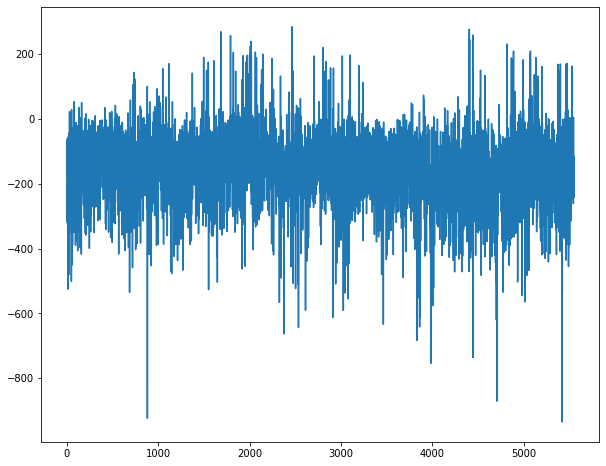

In [26]:
plt.rcParams['figure.figsize']=[10,8]
plt.plot(rewards)

In [27]:
df=pd.DataFrame(rewards)

In [ ]:
df.to_csv('rewards_main_algo_30_05.csv')

In [27]:
for i,r in enumerate (R_series):
    if(r==100):
        print(i)

In [28]:
dqn_solver.model.Qpolicy.weights

[<tf.Variable 'dense/kernel:0' shape=(8, 512) dtype=float32, numpy=
 array([[-0.10470529, -0.46629888, -0.8149456 , ..., -0.18868673,
         -0.7378071 , -0.37659392],
        [ 0.68352383,  0.2463692 ,  0.5064934 , ..., -0.09381859,
         -0.7775532 ,  0.43073064],
        [-0.03000955, -0.239059  ,  0.4232832 , ...,  0.28420195,
          0.41921628,  0.8248095 ],
        ...,
        [-0.07335401,  0.3649403 , -0.22122589, ..., -0.6643448 ,
         -0.21867679, -0.21299389],
        [ 0.0651519 , -0.6674954 ,  0.5886786 , ..., -0.40702978,
          0.58342326,  0.3447582 ],
        [-0.5269119 , -0.5634204 ,  0.3314767 , ...,  0.181051  ,
         -0.8665598 , -0.5207751 ]], dtype=float32)>,
 <tf.Variable 'dense/bias:0' shape=(512,) dtype=float32, numpy=
 array([-9.88612138e-03,  1.52384611e-02,  1.63692571e-02,  1.58144347e-02,
        -3.42444167e-03,  3.36172106e-03,  5.85101498e-03,  8.92919209e-03,
         1.37346173e-02, -4.46894811e-03,  1.55114112e-02,  3.42499814e-0

In [29]:
dqn_solver.model.Qtarget.weights

[<tf.Variable 'dense_4/kernel:0' shape=(8, 512) dtype=float32, numpy=
 array([[-0.10470529, -0.46629888, -0.8149456 , ..., -0.18868673,
         -0.7378071 , -0.37659392],
        [ 0.68352383,  0.2463692 ,  0.5064934 , ..., -0.09381859,
         -0.7775532 ,  0.43073064],
        [-0.03000955, -0.239059  ,  0.4232832 , ...,  0.28420195,
          0.41921628,  0.8248095 ],
        ...,
        [-0.07335401,  0.3649403 , -0.22122589, ..., -0.6643448 ,
         -0.21867679, -0.21299389],
        [ 0.0651519 , -0.6674954 ,  0.5886786 , ..., -0.40702978,
          0.58342326,  0.3447582 ],
        [-0.5269119 , -0.5634204 ,  0.3314767 , ...,  0.181051  ,
         -0.8665598 , -0.5207751 ]], dtype=float32)>,
 <tf.Variable 'dense_4/bias:0' shape=(512,) dtype=float32, numpy=
 array([-9.88612138e-03,  1.52384611e-02,  1.63692571e-02,  1.58144347e-02,
        -3.42444167e-03,  3.36172106e-03,  5.85101498e-03,  8.92919209e-03,
         1.37346173e-02, -4.46894811e-03,  1.55114112e-02,  3.4249981

In [30]:
S_series

[array([[-0.00664577,  1.4171242 , -0.6730174 ,  0.27571175,  0.00759112,
          0.15017484,  0.        ,  0.        ]], dtype=float32),
 array([[-4.1781645 ,  0.41302836,  4.165369  ,  2.5074039 ,  2.9774141 ,
          3.5520203 , -0.59184015, -2.9006116 ]], dtype=float32),
 array([[-6.8035784 ,  0.25546443,  8.704672  ,  2.8999293 ,  5.576273  ,
          6.3859887 , -2.540655  , -2.2497804 ]], dtype=float32),
 array([[-8.317361 ,  0.5008811, 12.323901 ,  2.6421113,  7.2027864,
          8.284648 , -4.4782453, -1.2927182]], dtype=float32),
 array([[-9.432463 ,  0.5940558, 14.046024 ,  2.911158 ,  8.307768 ,
          9.360001 , -5.332595 , -1.1835756]], dtype=float32),
 array([[-10.16547  ,   0.4475633,  15.283824 ,   2.9415898,   8.846097 ,
           9.914802 ,  -5.912229 ,  -1.0684597]], dtype=float32),
 array([[-10.741854  ,   0.48023093,  16.05063   ,   3.0030932 ,
           9.324736  ,  10.307575  ,  -6.280214  ,  -1.0028186 ]],
       dtype=float32),
 array([[-10.965517  

In [31]:
S_actual_series

[array([-0.00664577,  1.4171242 , -0.6730174 ,  0.27571175,  0.00759112,
         0.15017484,  0.        ,  0.        ], dtype=float32),
 array([-0.0134203 ,  1.4227381 , -0.68714726,  0.24943312,  0.01718159,
         0.19182718,  0.        ,  0.        ], dtype=float32),
 array([-0.02016563,  1.4277573 , -0.68240607,  0.2229642 ,  0.02495404,
         0.15546331,  0.        ,  0.        ], dtype=float32),
 array([-0.02687054,  1.4321866 , -0.67620516,  0.19675711,  0.03061211,
         0.1131719 ,  0.        ,  0.        ], dtype=float32),
 array([-0.03346233,  1.4368062 , -0.66559404,  0.20516615,  0.03695276,
         0.12682493,  0.        ,  0.        ], dtype=float32),
 array([-0.04027567,  1.4415617 , -0.6868165 ,  0.21121198,  0.04238096,
         0.10857402,  0.        ,  0.        ], dtype=float32),
 array([-0.04722052,  1.4457061 , -0.7022022 ,  0.18394944,  0.05001457,
         0.1526864 ,  0.        ,  0.        ], dtype=float32),
 array([-0.05420475,  1.4492509 , -0.7059

In [32]:
i=0
ep_lengthd=[]
for val in Done_series:
    if val==True:
        ep_lengthd.append(i)
        i=0
    else:
        i+=1
ep_lengthd.sort()
ep_lengthd[-2]

352

In [72]:
for i in range(300):
    print(O_series[i])
    print("--------")
    print(O_predicted_series[i])

[[0. 0. 0. 0. 0.]]
--------
[[0. 0. 0. 0. 0.]]
[[-0.01091166  1.4020762   0.0115569   0.          0.        ]]
--------
[[-0.27586782  0.14497356 -0.2177366   0.10288193  0.01683019]]
[[-0.01632118  1.3967619   0.01673517  0.          0.        ]]
--------
[[ 1.14169747e-01  1.64824569e+00 -5.21894276e-01  1.96238632e-20
   2.78408735e-26]]
[[-0.02171392  1.3914812   0.0221762   0.          0.        ]]
--------
[[1.37926966e-01 1.29694879e+00 1.43848121e-01 9.30710829e-21
  3.94337738e-27]]
[[-0.02701569  1.3856015   0.02584287  0.          0.        ]]
--------
[[1.59666449e-01 1.42429292e+00 6.97175786e-02 1.77122880e-24
  4.02171059e-32]]
[[-0.03240233  1.3799659   0.02930924  0.          0.        ]]
--------
[[1.92916781e-01 1.43414390e+00 6.08734414e-02 8.59898717e-25
  3.40235122e-33]]
[[-0.03777371  1.3737303   0.03297666  0.          0.        ]]
--------
[[1.45953566e-01 1.46776950e+00 1.02631502e-01 7.29282777e-25
  4.26781132e-34]]
[[-0.04312859  1.3668952   0.03684464  0.

In [66]:
print([x[0][0] for x in S_series[:50]])

[-0.0054925918, -5.2222633, -7.112486, -8.428797, -9.267365, -10.067233, -10.324633, -10.468637, -10.642929, -10.60531, -10.704699, -10.785103, -10.701191, -10.764763, -10.585121, -10.655081, -10.465824, -10.473465, -10.37282, -10.358494, -10.318902, -10.328688, -10.245611, -10.123028, -10.03088, -10.011064, -9.974822, -9.991652, -9.967913, -9.926203, -9.813879, -9.6064005, -9.580709, -9.519137, -9.406366, -9.259298, -9.206061, -9.078895, -9.045178, -9.10084, -9.036651, -8.984478, -8.975281, -8.815618, -8.765678, -8.745995, -8.581843, -8.586884, -8.4098425, -8.360388]


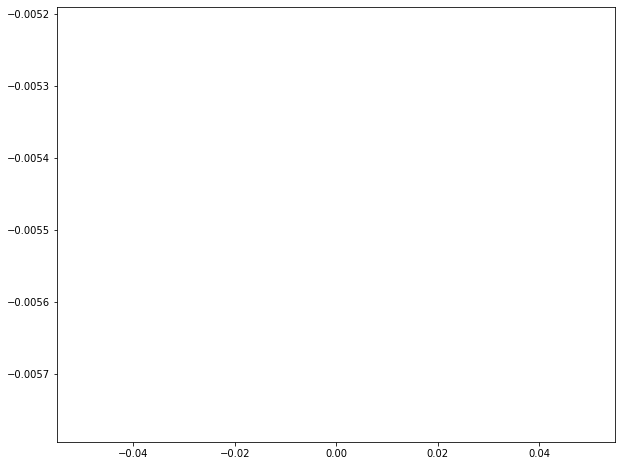

In [63]:
plt.plot([x[0] for x in S_series[:50][0]])


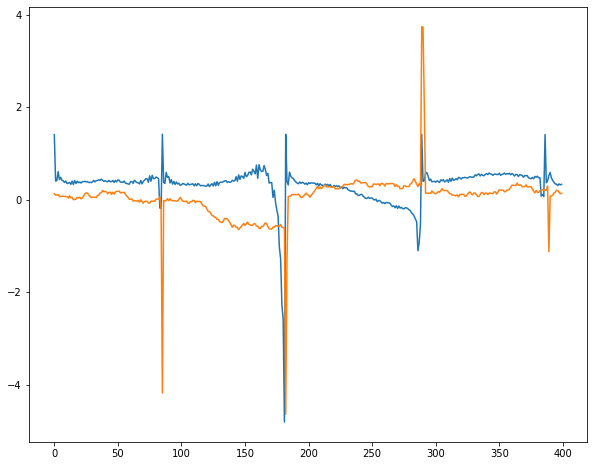

In [96]:
plt.plot([x[0][1] for x in S_series[:400]])
plt.plot([x[5] for x in S_actual_series[:400]])
plt.show()

In [38]:
for x in dqn_solver.memory :
    if(x[2]>10):
        print(x)

[array([[-1.168431  , -0.14622986,  2.0032084 , -0.08582126,  1.0331932 ,
         0.9798857 , -1.2902915 ,  0.30823317]], dtype=float32), 0.0, 19.60356334822816, array([[-2.0533402, -0.4515453,  1.9105127, -0.8252842,  0.5246682,
        -0.3008322, -2.1330419,  1.3394601]], dtype=float32), False]
[array([[-2.0533402, -0.4515453,  1.9105127, -0.8252842,  0.5246682,
        -0.3008322, -2.1330419,  1.3394601]], dtype=float32), 0.0, 29.58621170861598, array([[-0.00388002,  1.4032588 , -0.39324623, -0.34050548,  0.00471593,
         0.09324519,  0.        ,  0.        ]], dtype=float32), True]
[array([[-4.555787  , -0.1620419 ,  6.2933693 ,  0.52952904,  3.2270422 ,
         2.5899124 , -2.379121  , -0.14864376]], dtype=float32), 0.0, 19.6419898821655, array([[-4.9719095 , -0.77276057,  6.002187  , -0.09700017,  2.5568483 ,
         1.1078998 , -3.3242645 ,  0.8407719 ]], dtype=float32), False]
[array([[-4.818789  , -0.75039446,  5.051313  , -0.5824309 ,  2.490894  ,
         0.68822867,

In [27]:
env_render= gym.make(
        "LunarLander-v2",
        continuous = False,
        gravity = -10.0,
        enable_wind = True,
        wind_power  = 5.0,
        turbulence_power = 0.5,
        render_mode="human"
    )

In [28]:
main_list=data_collection_over_eps(10,env_render,dqn_solver,autoencoder)

In [ ]:
main_list[6][4]

[array([[0., 0., 0., 0., 0.]]),
 array([[-0.51162803, -0.05538566, -0.05117697,  0.46122825,  0.01297676]]),
 array([[ 3.35529715e-01,  1.21925831e+00, -1.82520807e-01,
          3.79082608e-16,  9.21750540e-21]]),
 array([[1.66592032e-01, 1.32622278e+00, 3.97803113e-02, 4.13401244e-19,
         7.54732071e-26]]),
 array([[ 2.26205736e-01,  1.40943992e+00, -3.04895118e-02,
          7.71371215e-22,  5.41850196e-30]]),
 array([[ 2.61052996e-01,  1.44057786e+00, -1.49908736e-02,
          3.24557224e-23,  5.92744555e-32]]),
 array([[2.41843611e-01, 1.46750581e+00, 3.35764214e-02, 3.40613297e-24,
         2.89667265e-33]]),
 array([[2.51477152e-01, 1.48397672e+00, 7.69137666e-02, 5.80479797e-25,
         3.09840635e-34]]),
 array([[2.82012850e-01, 1.48549306e+00, 9.68813226e-02, 1.89712876e-25,
         7.76686713e-35]]),
 array([[3.05021197e-01, 1.48201406e+00, 1.03396825e-01, 1.09934842e-25,
         4.02242573e-35]]),
 array([[3.14382941e-01, 1.46997154e+00, 1.20430879e-01, 1.60849971e

In [29]:
env_render.close()